## Creating dummy variables
Being able to include categorical features in the model building process can enhance performance as they may add information that contributes to prediction accuracy.

In [22]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.linear_model import Ridge,LogisticRegression, LinearRegression

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

In [2]:
music_df = pd.read_csv('music_clean.csv')
df = pd.read_csv('diabetes_clean.csv')

In [3]:
X = df.drop('diabetes', axis=1).values
y = df['diabetes'].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [5]:
# Create music_dummies
music_dummies = pd.get_dummies(music_df, drop_first=True)

# Print the new DataFrame's shape
print("Shape of music_dummies: {}".format(music_dummies.shape))

Shape of music_dummies: (1000, 13)


## Regression with categorical features
We  have created music_dummies, containing binary features for each song's genre, it's time to build a ridge regression model to predict song popularity.

In [6]:
# Create X and y
X = music_dummies.drop("popularity", axis=1).values
y = music_dummies["popularity"].values

# Instantiate a ridge model
ridge = Ridge(alpha=0.2)

# Perform cross-validation
scores = cross_val_score(ridge, X, y,  scoring="neg_mean_squared_error")

# Calculate RMSE
rmse = np.sqrt(-scores)
print("Average RMSE: {}".format(np.mean(rmse)))
print("Standard Deviation of the target array: {}".format(np.std(y)))

Average RMSE: 9.876017515273318
Standard Deviation of the target array: 14.02156909907019


## Dropping missing data
We are going to tidy the music_df dataset. We will create a pipeline to impute missing values and build a KNN classifier model, then use it to predict whether a song is of the "Rock" genre.

In [7]:
# Print missing values for each column
print(music_df.isna().sum().sort_values())

# Remove values where less than 5% are missing
music_df = music_df.dropna(subset=["genre", "popularity", "loudness", "liveness", "tempo"])

# Convert genre to a binary feature
music_df["genre"] = np.where(music_df["genre"] == "Rock", 1, 0)

print(music_df.isna().sum().sort_values())
print("Shape of the `music_df`: {}".format(music_df.shape))

Unnamed: 0          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
genre               0
dtype: int64
Unnamed: 0          0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
genre               0
dtype: int64
Shape of the `music_df`: (1000, 13)


In [8]:
# Import modules
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Instantiate an imputer
imputer = SimpleImputer()

# Instantiate a knn model
knn = KNeighborsClassifier(n_neighbors=3)

# Build steps for the pipeline
steps = [("imputer", imputer), 
         ("knn", knn)]

## Pipeline for song genre prediction: II
Having set up the steps of the pipeline in the previous exercise, you will now use it on the music_df dataset to classify the genre of songs. What makes pipelines so incredibly useful is the simple interface that they provide.

In [9]:
# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[108  43]
 [ 32  48]]


## Centering and scaling for regression
Now we have seen the benefits of scaling your data, we will use a pipeline to preprocess the music_df features and build a lasso regression model to predict a song's loudness.

In [10]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Create pipeline steps
steps = [("scaler", StandardScaler()),
         ("lasso", Lasso(alpha=0.5))]

# Instantiate the pipeline
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

# Calculate and print R-squared
print(pipeline.score(X_test, y_test))

-6.287473975308266e-05


## Centering and scaling for classification
Now we will bring together scaling and model building into a pipeline for cross-validation.

our task is to build a pipeline to scale features in the music_df dataset and perform grid search cross-validation using a logistic regression model with different values for the hyperparameter C. The target variable here is "genre", which contains binary values for rock as 1 and any other genre as 0.

In [11]:
# Build the steps
steps = [("scaler", StandardScaler()),
         ("logreg", LogisticRegression())]
pipeline = Pipeline(steps)

# Create the parameter space
parameters = {"logreg__C": np.linspace(0.001, 1.0, 20)}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=21)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training data
cv.fit(X_train, y_train)
print(cv.best_score_, "\n", cv.best_params_)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modu

0.05500000000000001 
 {'logreg__C': 0.6319473684210526}


## Centering and scaling for classification
Now we will bring together scaling and model building into a pipeline for cross-validation.

In [12]:
# Build the steps
steps = [("scaler", StandardScaler()),
         ("logreg", LogisticRegression())]
pipeline = Pipeline(steps)

# Create the parameter space
parameters = {"logreg__C": np.linspace(0.001, 1.0, 20)}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=21)

# Instantiate the grid search object
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training data
cv.fit(X_train, y_train)
print(cv.best_score_, "\n", cv.best_params_)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modu

0.05500000000000001 
 {'logreg__C': 0.6319473684210526}


## Visualizing regression model performance
Now we have seen how to evaluate multiple models out of the box, we will build three regression models to predict a song's "energy" levels.

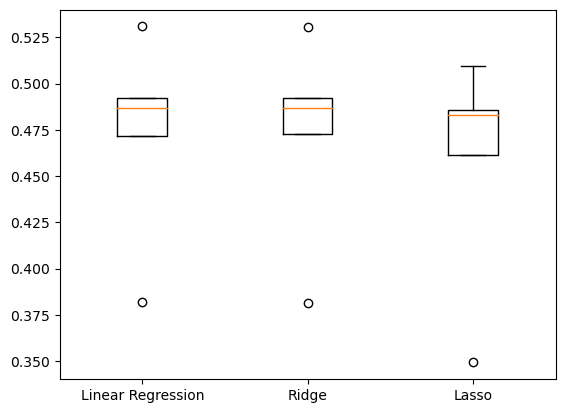

In [19]:
models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.1), "Lasso": Lasso(alpha=0.1)}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train)
  
  # Append the results
  results.append(cv_scores)
  
# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()

## Pipeline for predicting song popularity
For the final exercise, we will build a pipeline to impute missing values, scale features, and perform hyperparameter tuning of a logistic regression model. The aim is to find the best parameters and accuracy when predicting song genre!

In [24]:
# Create steps
steps = [("imp_mean", SimpleImputer()), 
         ("scaler", StandardScaler()), 
         ("logreg", LogisticRegression())]

# Set up pipeline
pipeline = Pipeline(steps)
params = {"logreg__solver": ["newton-cg", "saga", "lbfgs"],
         "logreg__C": np.linspace(0.001, 1.0, 10)}

# Create the GridSearchCV object
tuning = GridSearchCV(pipeline, param_grid=params)
tuning.fit(X_train, y_train)
y_pred = tuning.predict(X_test)

# Compute and print performance
print("Tuned Logistic Regression Parameters: {}, Accuracy: {}".format(tuning.best_params_, tuning.score(X_test, y_test)))

C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter wa

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Tuned Logistic Regression Parameters: {'logreg__C': 0.667, 'logreg__solver': 'newton-cg'}, Accuracy: 0.04
